# Team CompSpec

## Intro
* **Date**: 11/30/2020
* **What**: Just training a bunch of CompSpec networks, and then taking their average classification.
* **Why**: The idea is that having multiple opinions on each classification should yield better results.  Maybe there's a fluke in one network that isn't present in the others, so we don't make simple mistakes.  Basically double checking.
* **Hopes**: I hope that just having more networks significantly increases classification accuracy.  That'd be dope.
* **Limitations**: Because all the networks are training the same way, they may have the exact same deficiencies as each other, which means we might not see a huge jump in classification due to a lack of diversity.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, L])
flat_test = np.reshape(test_X, [-1, L])

In [2]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   

In [29]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size

zeta: Brutality of exponent
beta: giver of life lol

Returns: (synapse_weights, neuron specialization values)
"""
def run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B, :]

            w_mul_v = w @ v.T 
            o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

            c = (np.exp(-1 * zeta * s) + beta) / (1 - o)

            wins = np.argmax(c, axis=0)     

            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

            win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

            v_update = win_mask @ v

            del_syn = (v_update - (win_avg * w)) * (np.exp(-1 * zeta * s) + beta) * xi

            w += del_syn

            s[wins] *= (1 - phi)
            s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)

#         draw_weights(w, Kx, Ky)

    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, s)

In [36]:
def team_wta(super_w):
    size = 60000
    totals = np.zeros((10, size))
    
    classes = []
    
    for w in super_w:
        wins = np.argmax(w @ flat_x.T, axis=0)
        w_cls_mask = np.zeros((w.shape[0], 10))
        
        for (syn_win, lbl) in zip(wins, train_y):
            w_cls_mask[syn_win][lbl] += 1
                        
        w_cls = np.argmax(w_cls_mask, axis=1)
        classes.append(w_cls)
        
    test_len = flat_test.shape[0]
        
    total_clsfn_mask = np.zeros((test_len, 10))
    
    for (w, cls) in zip(super_w, classes):
        wins = np.argmax(w @ flat_test.T, axis=0)
        w_clsfn = cls[wins]
        
        w_clsfn_mask = np.zeros((test_len, 10))
        w_clsfn_mask[np.arange(test_len), w_clsfn] = 1
        
        total_clsfn_mask += w_clsfn_mask
        
    clsfn = np.argmax(total_clsfn_mask, axis=1)
    
    correct = np.zeros(test_len)
    
    correct[clsfn == test_y] = 1
    
    total_correct = np.sum(correct)
    
    incorrect = []
    
    for i in range(test_len):
        if not correct[i]:
            incorrect.append(i)
    
    print("Accuracy: ", str(100 * total_correct / test_len) + '%')
    
    return incorrect

## Analysis Dialog

Alright, got the code working.  Let's see if these networks do better alone or together.

In [32]:
# %matplotlib inline
# %matplotlib notebook
# fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 1
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

B = 500 #Batch size

networks = 5 #Number of networks being trained

super_w = []

for i in range(networks):
    print("Network:", i)
    (w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
    team_wta([w])
    super_w.append(w)
    
print("Team accuracy:")
team_wta(super_w)

Network: 0


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 219.96it/s]


Max val:  0.34094397048430963 Min value:  0.2483987644817894 Mean val:  0.29402434668905486 Std:  0.017589592622175788
Elapsed time:  0.7458083629608154  seconds
Accuracy:  88.32%
Network: 1


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 216.40it/s]


Max val:  0.3402521185941762 Min value:  0.24544519733534195 Mean val:  0.29767919493815803 Std:  0.01632850807413644
Elapsed time:  0.7499959468841553  seconds
Accuracy:  89.74%
Network: 2


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 215.61it/s]


Max val:  0.34032624047859755 Min value:  0.21659836007458091 Mean val:  0.29445697886198013 Std:  0.019062690525810357
Elapsed time:  0.7519898414611816  seconds
Accuracy:  87.43%
Network: 3


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 219.14it/s]


Max val:  0.34410185276715144 Min value:  0.24133381670339138 Mean val:  0.2950620113247786 Std:  0.01919359112078258
Elapsed time:  0.7431707382202148  seconds
Accuracy:  86.61%
Network: 4


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 216.42it/s]


Max val:  0.33796716288758344 Min value:  0.23932637830759712 Mean val:  0.2948954672032907 Std:  0.016905295039499724
Elapsed time:  0.7489984035491943  seconds
Accuracy:  88.09%
Team accuracy:
Accuracy:  90.17%


Well, the team did just a bit better than the networks individually.  Let's try training on more epochs.

In [37]:
# %matplotlib inline
# %matplotlib notebook
# fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

B = 500 #Batch size

networks = 5 #Number of networks being trained

super_w = []

for i in range(networks):
    print("Network:", i)
    (w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
    team_wta([w])
    super_w.append(w)
    
print("Team accuracy:")
incorrect = team_wta(super_w)

Network: 0


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 208.88it/s]


Max val:  0.8992817186023144 Min value:  0.7177663788119626 Mean val:  0.8133849867900413 Std:  0.03421145410720975
Elapsed time:  7.583030700683594  seconds
Accuracy:  90.16%
Network: 1


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 203.24it/s]


Max val:  0.8996660386610056 Min value:  0.7410847859766841 Mean val:  0.8145083394283665 Std:  0.03340586421882138
Elapsed time:  7.5796778202056885  seconds
Accuracy:  89.52%
Network: 2


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 200.52it/s]


Max val:  0.9033290583730036 Min value:  0.7301144399073253 Mean val:  0.8151578158402184 Std:  0.03479370346215567
Elapsed time:  7.671431303024292  seconds
Accuracy:  89.66%
Network: 3


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 207.26it/s]


Max val:  0.8982635066748578 Min value:  0.7233803803611025 Mean val:  0.812504727720371 Std:  0.03243139404977973
Elapsed time:  7.666987180709839  seconds
Accuracy:  90.3%
Network: 4


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 206.74it/s]


Max val:  0.9006896555826389 Min value:  0.7395341658689543 Mean val:  0.8148098503925496 Std:  0.03458256004155184
Elapsed time:  7.6083221435546875  seconds
Accuracy:  89.42%
Team accuracy:
Accuracy:  90.71%


Hmm. It does basically 0.4% better as a team than the networks did individually.  Let's see which inputs are giving this network trouble.

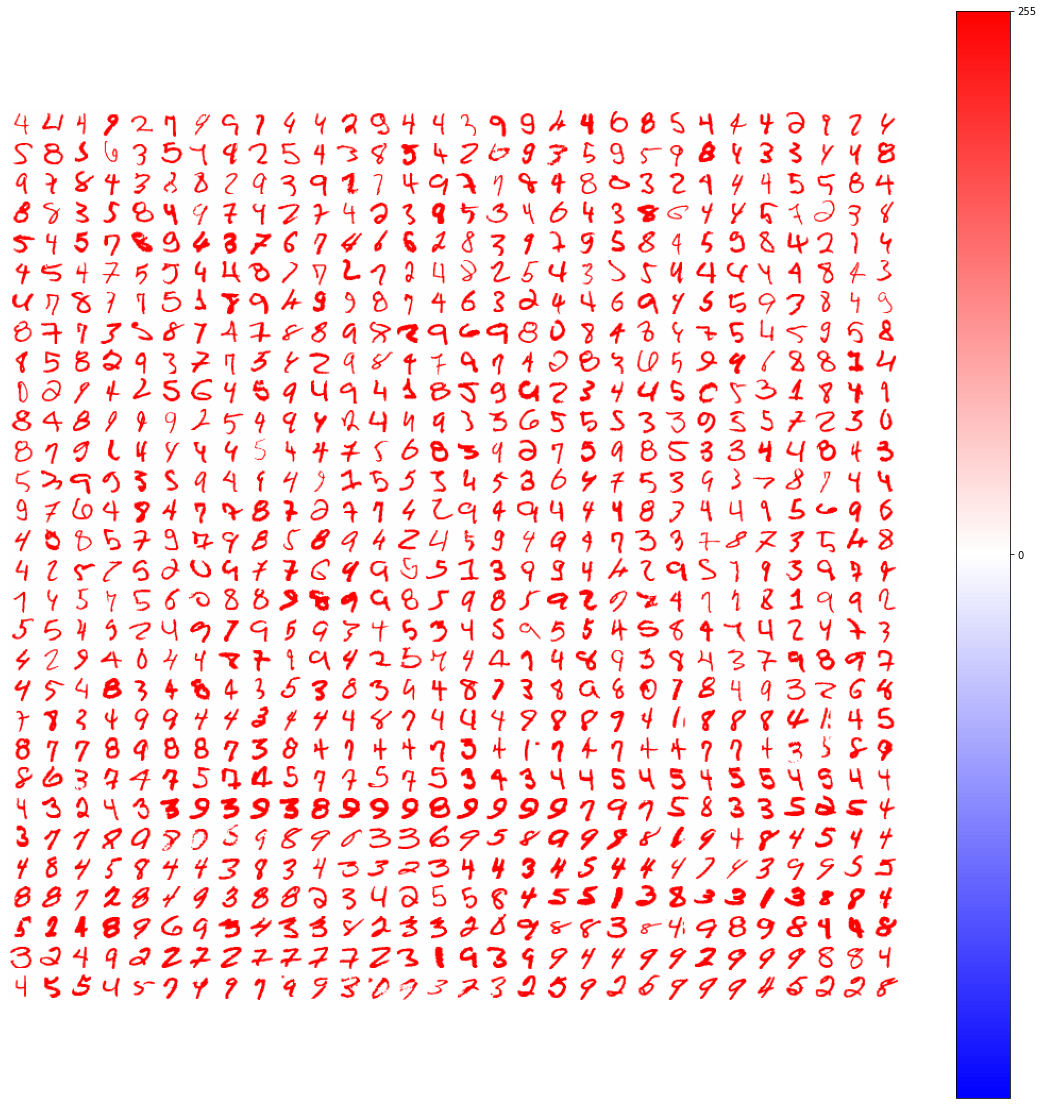

In [43]:
fig=plt.figure(figsize=(20,20))
draw_weights(flat_test[incorrect], 30, 30)

I'm not sure what I thought I was going to get out of that.  However, I guess I did think that the digits would be more gross than those.  A lot of those actually kinda look like gimmes.  I'm going to draw the last weights learned and see if there's overlap.

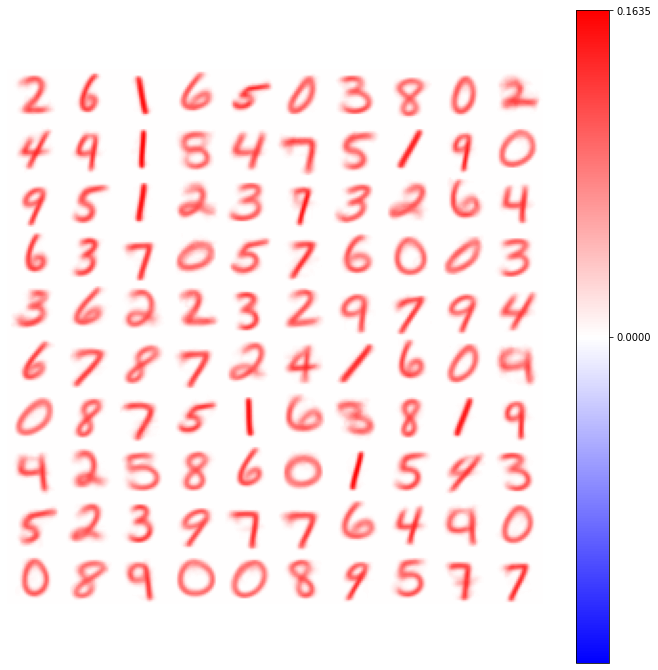

In [47]:
fig=plt.figure(figsize=(12,12))
draw_weights(super_w[4], 10, 10)

Well, ok.  There isn't a whole lot I can say about this, I suppose.  Before I move on to more neurons, I'm going to try the trial, but with 10 networks.

In [48]:
# %matplotlib inline
# %matplotlib notebook
# fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

B = 500 #Batch size

networks = 10 #Number of networks being trained

super_w = []

for i in range(networks):
    print("Network:", i)
    (w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
    team_wta([w])
    super_w.append(w)
    
print("Team accuracy:")
incorrect = team_wta(super_w)

Network: 0


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 208.89it/s]


Max val:  0.8990648334192778 Min value:  0.7355439728232755 Mean val:  0.8136795950049796 Std:  0.03408853793086703
Elapsed time:  7.655339956283569  seconds
Accuracy:  89.99%
Network: 1


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 207.81it/s]


Max val:  0.9062432903768424 Min value:  0.7382771159938296 Mean val:  0.8153162484376054 Std:  0.034763734080129415
Elapsed time:  7.586792230606079  seconds
Accuracy:  89.94%
Network: 2


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 207.08it/s]


Max val:  0.9069071229017496 Min value:  0.7295901719518122 Mean val:  0.8134357764867438 Std:  0.0345585207687318
Elapsed time:  7.577642917633057  seconds
Accuracy:  90.05%
Network: 3


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 208.51it/s]


Max val:  0.9017875547589399 Min value:  0.7423089042546063 Mean val:  0.8140721776037323 Std:  0.033410983419424355
Elapsed time:  7.559861660003662  seconds
Accuracy:  90.71%
Network: 4


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 207.09it/s]


Max val:  0.8984387159321537 Min value:  0.7348213025524355 Mean val:  0.813903811706025 Std:  0.033127084490852506
Elapsed time:  7.585062742233276  seconds
Accuracy:  90.16%
Network: 5


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 208.16it/s]


Max val:  0.9020478725751518 Min value:  0.7335829359721158 Mean val:  0.8151750181833652 Std:  0.035125148479372904
Elapsed time:  7.557473182678223  seconds
Accuracy:  89.83%
Network: 6


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 207.45it/s]


Max val:  0.9002875621108395 Min value:  0.7368458071962484 Mean val:  0.8151298431146139 Std:  0.03476365363640507
Elapsed time:  7.578222751617432  seconds
Accuracy:  90.07%
Network: 7


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 206.06it/s]


Max val:  0.9006152562456262 Min value:  0.7419937958219333 Mean val:  0.8146024731373787 Std:  0.034030095606583745
Elapsed time:  7.62158465385437  seconds
Accuracy:  90.78%
Network: 8


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 207.09it/s]


Max val:  0.9015226400853291 Min value:  0.7328047375897069 Mean val:  0.8140635876341618 Std:  0.033728820533152105
Elapsed time:  7.615638971328735  seconds
Accuracy:  90.22%
Network: 9


100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 209.22it/s]


Max val:  0.898382632171964 Min value:  0.7116218753357628 Mean val:  0.8128678886353287 Std:  0.03272401776955039
Elapsed time:  7.562131404876709  seconds
Accuracy:  89.95%
Team accuracy:
Accuracy:  91.34%


Ok.  It's just a bit better.  Let's check out the incorrects.

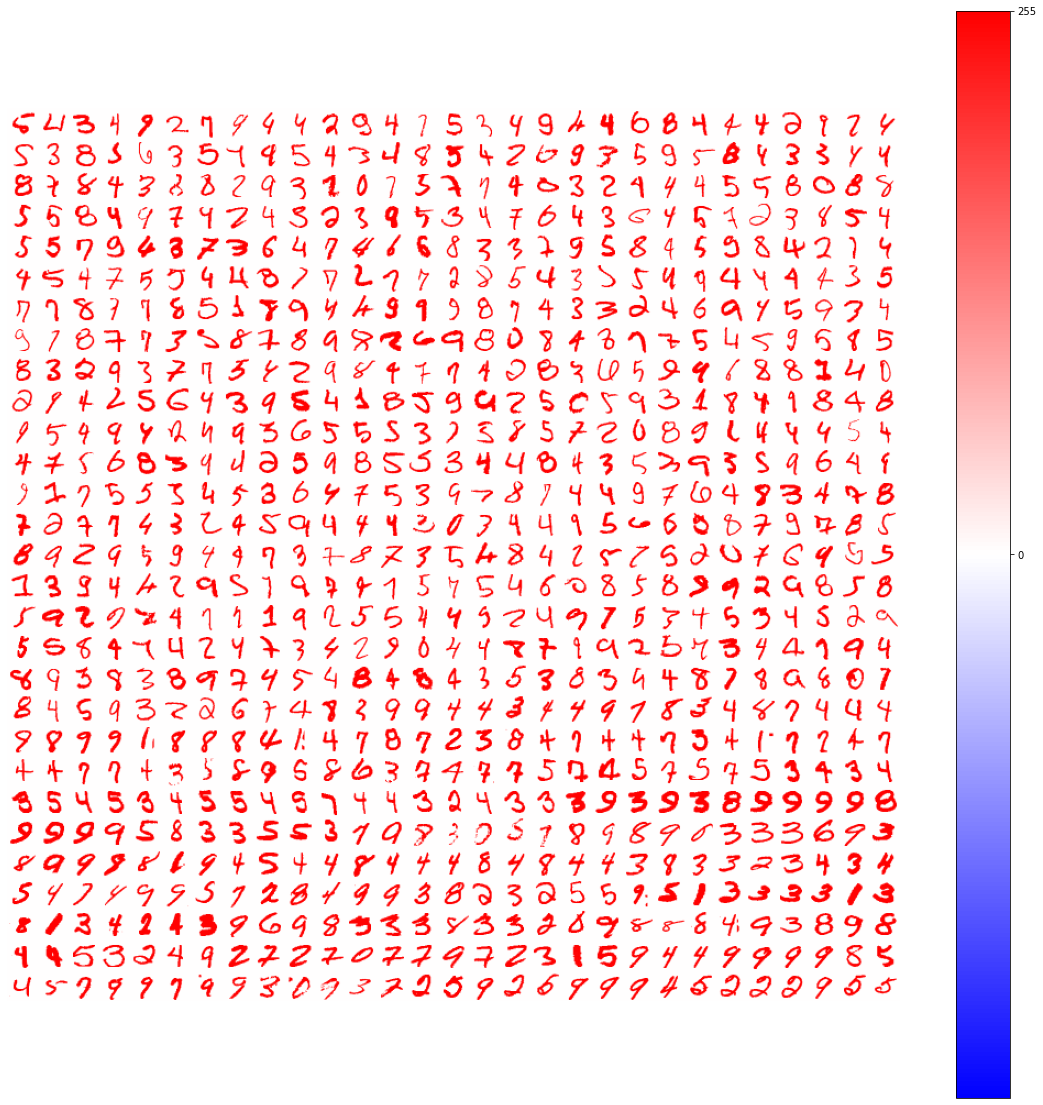

In [52]:
fig=plt.figure(figsize=(20,20))
draw_weights(flat_test[incorrect], 29, 29)

Hmm. Ok. I guess what I will say seems to be the case is that if the digits were taken apart into their constituent pieces, I imagine you'd get a better accuracy.  Hence, CNNs.  Ok, Imma try 400 and 1,600 neurons, then we're wrapping this mother fucker up.

In [53]:
# %matplotlib inline
# %matplotlib notebook
# fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

B = 500 #Batch size

networks = 5 #Number of networks being trained

super_w = []

for i in range(networks):
    print("Network:", i)
    (w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
    team_wta([w])
    super_w.append(w)
    
print("Team accuracy:")
incorrect = team_wta(super_w)

Network: 0


100%|███████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 44.35it/s]


Max val:  0.9272963398593749 Min value:  0.6099361665702335 Mean val:  0.8100171499855437 Std:  0.04754315892300126
Elapsed time:  28.88668465614319  seconds
Accuracy:  94.17%
Network: 1


100%|███████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 44.50it/s]


Max val:  0.9283704663465475 Min value:  0.6565917537812838 Mean val:  0.8118788698152258 Std:  0.04458418701513869
Elapsed time:  28.763611793518066  seconds
Accuracy:  93.76%
Network: 2


100%|███████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 44.73it/s]


Max val:  0.9258261914423183 Min value:  0.5247001147011083 Mean val:  0.8104506449355796 Std:  0.04835219413515337
Elapsed time:  28.833551168441772  seconds
Accuracy:  94.09%
Network: 3


100%|███████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 44.38it/s]


Max val:  0.9253263522498679 Min value:  0.5765850447556474 Mean val:  0.8094478980206435 Std:  0.05011377069064535
Elapsed time:  28.772136449813843  seconds
Accuracy:  94.15%
Network: 4


100%|███████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 43.19it/s]


Max val:  0.9270169462603727 Min value:  0.6582079212962467 Mean val:  0.8119967047058851 Std:  0.04588957945605644
Elapsed time:  28.884169340133667  seconds
Accuracy:  94.17%
Team accuracy:
Accuracy:  94.8%


Well, great.  

We get maybe a 0.6% bump.  That's kinda a dumpster fire.

Whatever.  Let's try 1,600 and call this experiment quits.

Wait, first I'm going check out the incorrects.

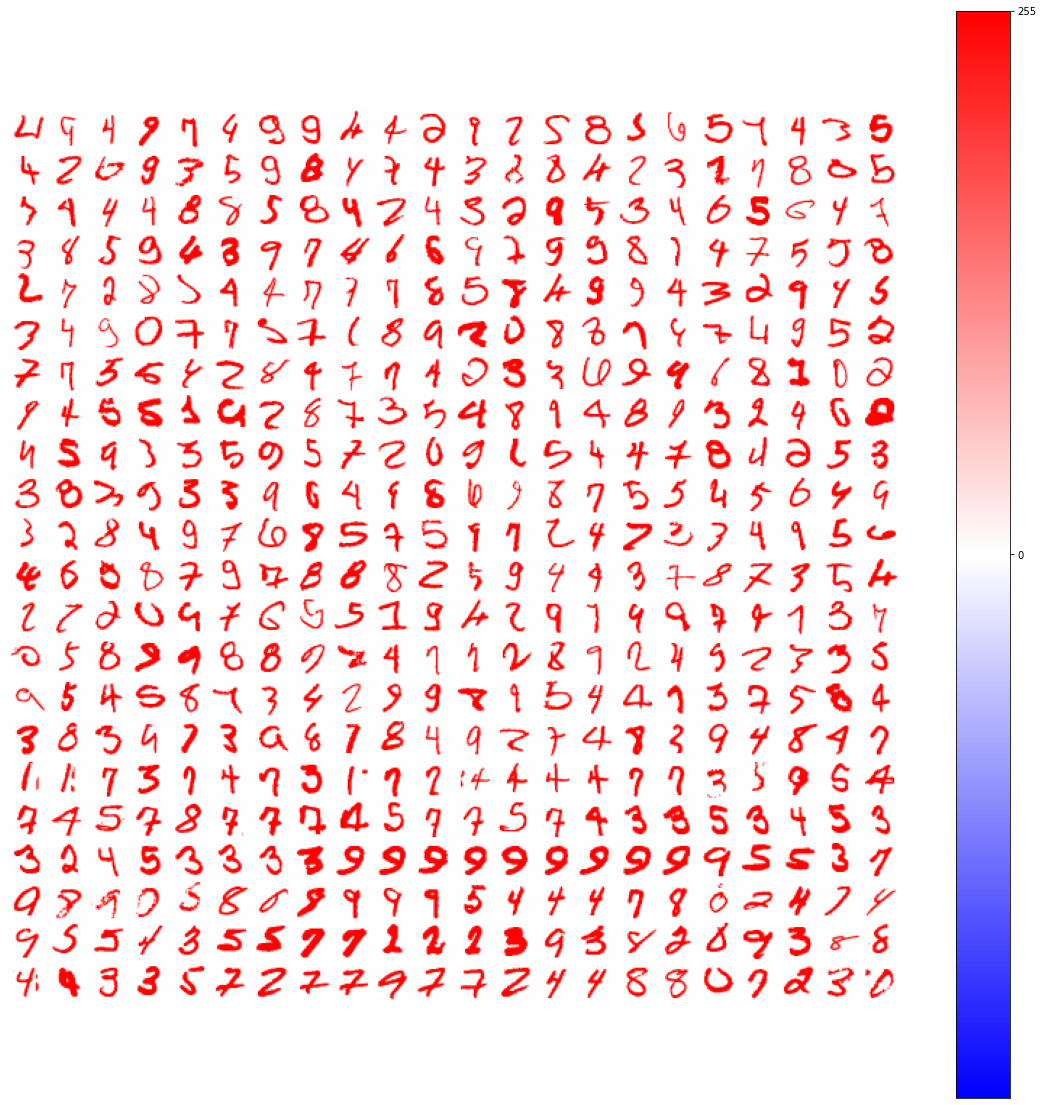

In [55]:
fig=plt.figure(figsize=(20,20))
draw_weights(flat_test[incorrect], 22, 22)

Some of those are understandable, but I'll tell you what I don't like.  That line of 9s near the bottom should be pretty easy to classify.  But I think is understanding it in terms of its constituent parts.  So I see the loop on top, and the line on bottom, and I see a fucking nine.  

I feel like the same thing applies to a bunch of these input vectors.  But yeah, I think neurons trained on small parts of the network will get us from zero to hero.  

Ok, let's do 1,600 neurons, and let's get the f out.

In [56]:
# %matplotlib inline
# %matplotlib notebook
# fig=plt.figure(figsize=(12,12))

Kx = 40
Ky = 40
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

B = 500 #Batch size

networks = 5 #Number of networks being trained

super_w = []

for i in range(networks):
    print("Network:", i)
    (w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
    team_wta([w])
    super_w.append(w)
    
print("Team accuracy:")
incorrect = team_wta(super_w)

Network: 0


100%|███████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.80it/s]


Max val:  0.9218669832024046 Min value:  0.12912810940566458 Mean val:  0.593537473393122 Std:  0.11683542218222462
Elapsed time:  103.77831649780273  seconds
Accuracy:  95.91%
Network: 1


100%|███████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.51it/s]


Max val:  0.9229868281703898 Min value:  0.17566325545558606 Mean val:  0.5937752473958424 Std:  0.11594704121211045
Elapsed time:  104.92872643470764  seconds
Accuracy:  95.8%
Network: 2


100%|███████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.74it/s]


Max val:  0.9152709151124292 Min value:  0.1875905253238657 Mean val:  0.5924948774063814 Std:  0.11888136519751581
Elapsed time:  103.86149716377258  seconds
Accuracy:  96.01%
Network: 3


100%|███████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.77it/s]


Max val:  0.909881100134 Min value:  0.19778344353520855 Mean val:  0.5944828518050391 Std:  0.11752988923457357
Elapsed time:  103.67191076278687  seconds
Accuracy:  95.77%
Network: 4


100%|███████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.75it/s]


Max val:  0.9071320460873206 Min value:  0.1549134041221619 Mean val:  0.5924835431942485 Std:  0.1202963632244795
Elapsed time:  104.38383460044861  seconds
Accuracy:  95.83%
Team accuracy:
Accuracy:  96.45%


Hmm, ok.  I'm actually pretty happy about that one.  Got a bump of 0.44% over the max.  That's not too bad.  

Still, it's not great.  Let's check out the incorrects.

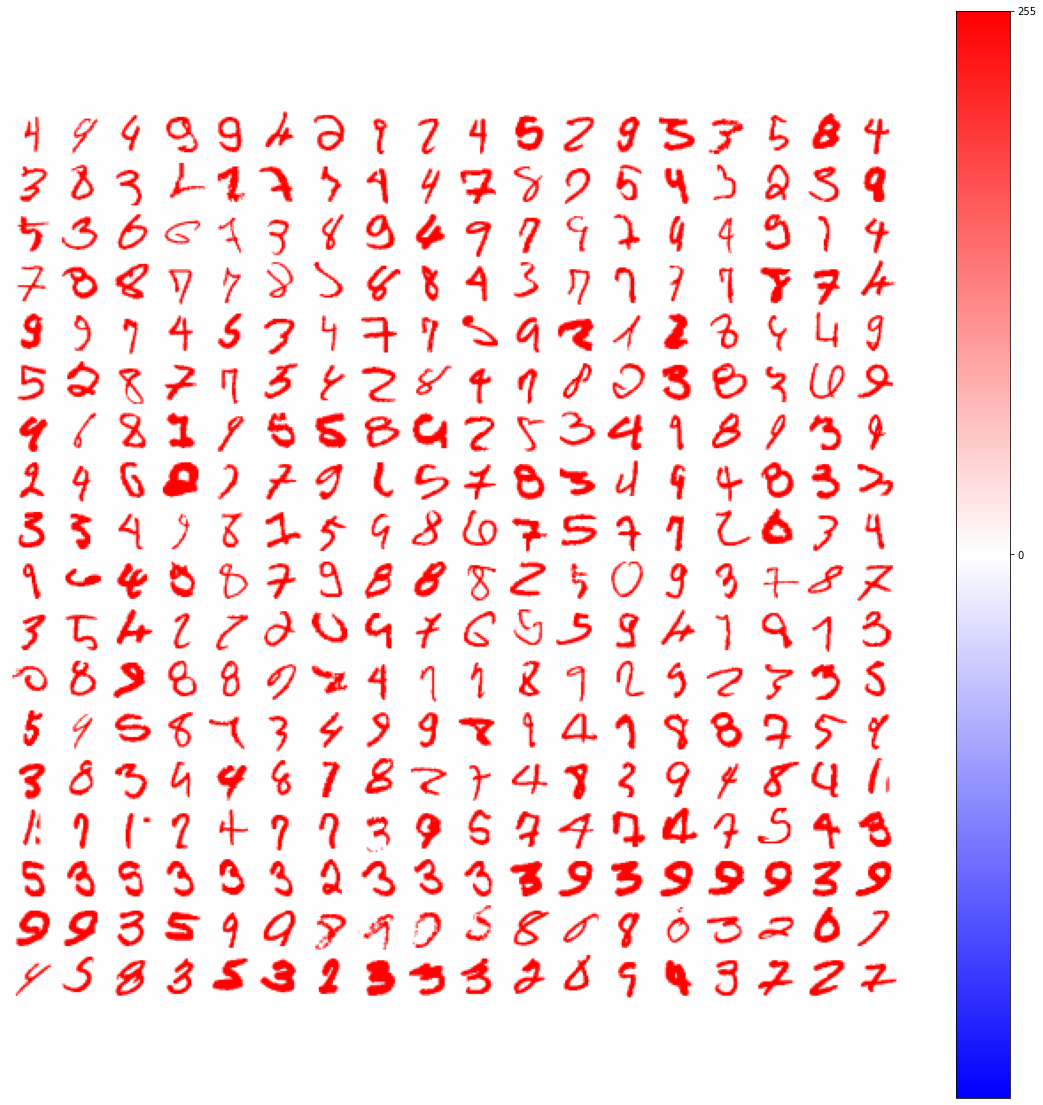

In [59]:
fig=plt.figure(figsize=(20,20))
draw_weights(flat_test[incorrect], 18, 18)

I mean, some of those are pretty wonky, but still, you have that line of impossible nines, some of those threes are irresponsibly recognizable.  

Yeah, time to close this bad boi up.

## Conclusions

So yeah, team CompSpec is kinda a bust.  It does a bit better, but certainly nothing to write home about.  I think there are two main reasons for this.  

1. The training conditions for each of the networks is basically identical, which means we're probably not getting a ton of diversity between the prototypes in the different networks.  What we need is a way to have more diversity in the prototypes.  Luckily, I have an idea for that.

2. As I've mentioned many times by this point, I think a fundamental aspect of intelligence is the ability to recognize wholes from constituents.  With that said, this fucking network doesn't learn to find constituent parts.  It's basically just trying to recognize a variety of wholes using the prototypes for a variety of whole.  It has got to be easier to break things down into parts, and to use those parts to recognize the whole.  Got an idea for that as well.

So yeah, let's get down to business, to defeat the motherfucking hun.

## Next Steps

To address 1. from the conclusions section, basically, I think the idea should be to "randomize" inhibitory connections.  That means that neurons aren't competing with everybody, which means there are multiple winners.  Having multiple winners feels like a good thing to do because then you have a less brittle representation of neurons responding strongly to a given input.  Having all those winners respond allows the network to have a more robust "idea" about the different inputs.  So yeah, I think this is the next experiment.  

To address 2. from conclusions, I think this one is pretty straight-forward.  Basically just connect each neuron to a local subset of the inputs.  Then, have the neurons compete locally.  Badabing, badaboom.  

Yeah, so I'm going 1 first, and then 2.